In [1]:
import numpy as np
import poligrain as plg
import xarray as xr

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("C:/Users/a002461/OPENSENSE/pypwsqc/src"))

import pypwsqc

## Read data

In [3]:
ds_pws = xr.open_dataset("prepared_OpenMRG_dataset.nc")

### Create distance matrix

Calculate the distances between all stations in our data set. If your data set has a large number of stations this can take some time.

In [5]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Select range for neighbouring checks

The quality control is performed by comparing time series of each station with the time series of neighbouring stations within a specificed range `max_distance`. The selected range depends on the use case and area of interest. In this example, we use 10'000 meters. `max_distance` is called `d` in the [original publication](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731).

### Select considered range around each station

In [6]:
max_distance = 10e3

## Quality control

Now the data set is prepared to run the quality control.

### Faulty Zeros filter

Conditions for raising Faulty Zeros flag:

* Median rainfall of neighbouring stations within range max_distance is larger than zero for at least nint time intervals while the station itself reports zero rainfall.
* The FZ flag remains 1 until the station reports nonzero rainfall.
* Filter cannot be applied if less than `n_stat` neighbours are reporting data (FZ flag is set to -1)
* NOTE! The filter cannot be applied if the station has reported NaN data in the last `nint` time steps. This gives more -1 flags than in the original R-implementation that does not use this condition. This choice was done to ensure that timesteps without data at the evaluated station is not mistakenly being interpreted as timesteps who have passed the quality control (if they would have been flagged with 0) or as time steps with a Faulty Zero issue (if they would have been flagged with 1).
  
For settings for parameter `nint` and `n_stat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

#### Set FZ parameters

In [7]:
nint = 6
n_stat = 3

#### Run FZ filter

In [8]:
%%time

ds_pws_filtered = pypwsqc.flagging.fz_filter(ds_pws, nint, n_stat, distance_matrix, max_distance)

CPU times: total: 5.72 s
Wall time: 5.9 s


#### Set HI parameters

In [9]:
hi_thres_a=0.4
hi_thres_b=10
nint = 6
n_stat = 3

#### Run HI filter

In [10]:
%%time

ds_pws_filtered = pypwsqc.flagging.hi_filter(ds_pws, hi_thres_a, hi_thres_b, nint, n_stat, distance_matrix, max_distance)

CPU times: total: 15.6 ms
Wall time: 19 ms


In [13]:
ds_pws_filtered.to_netcdf('FZ_HI_filtered_nstat_3.nc')

#### Set SO parameters

In [12]:
import numpy as np
import numpy.typing as npt
import pandas as pd

In [13]:
evaluation_period = 4032
mmatch = 200
gamma = 0.15
n_stat = 3

In [14]:
bias_corr = False 
beta = 0.2
dbc = 1

#### Run SO filter

In [15]:
def so_filter_one_station(ds_station, ds_neighbors, evaluation_period, mmatch):
    """Support function to Station Outlier filter.

    Parameters
    ----------
    da_station
        rainfall time series of evaluated station.
    da_neighbors
        rainfall time series of neighboring stations.
    evaluation_period
        length of (rolling) window for correlation calculation
        [timesteps]
    mmatch
        threshold for number of matching rainy intervals in
        evaluation period [timesteps]

    Returns
    -------
    npt.NDArray
        number of neighbors with enough wet time steps
    """
    # rolling pearson correlation
    s_rainfall = ds_station.rainfall.to_series()
    s_neighbors_rain = ds_neighbors.rainfall.to_series()
    corr = s_rainfall.rolling(evaluation_period, min_periods=1).corr(s_neighbors_rain)
    ds = xr.Dataset.from_dataframe(pd.DataFrame({"corr": corr}))

    # create dataframe of neighboring stations
    df_nbrs = ds_neighbors.to_dataframe()
    df_nbrs = df_nbrs["rainfall"].unstack("id")  # noqa: PD010

    # boolean arrays - True if a rainy time step, False if 0 or NaN.
    rainy_timestep_at_nbrs = df_nbrs > 0

    # rolling sum of number of rainy timesteps in
    # last evaluation_period period, per neighbor.
    wet_timesteps_last_evaluation_period_period = rainy_timestep_at_nbrs.rolling(
        evaluation_period, min_periods=1
    ).sum()

    # per time step and neighbor, does the nbr have more than
    # mmatch wet time steps in the last evaluation_period period? (true/false)
    enough_matches_per_nbr = wet_timesteps_last_evaluation_period_period > mmatch

    # summing how many neighbors that have enough matches per time step
    nr_nbrs_with_enough_matches = enough_matches_per_nbr.sum(axis=1)

    ds["matches"] = xr.DataArray.from_series(nr_nbrs_with_enough_matches)

    return ds

In [17]:
%%time

# For each station (ID), get the index of the first non-NaN rainfall value
first_non_nan_index = ds_pws_filtered["rainfall"].notnull().argmax(dim="time")  # noqa: PD004

ds_pws_filtered["so_flag"] = xr.DataArray(
    np.ones((len(ds_pws_filtered.id), len(ds_pws_filtered.time))) * -999, dims=("id", "time")
)
ds_pws_filtered["median_corr_nbrs"] = xr.DataArray(
    np.ones((len(ds_pws_filtered.id), len(ds_pws_filtered.time))) * -999, dims=("id", "time")
)

for i in range(len(ds_pws_filtered.id)):
    BCF_prev = dbc
    ds_station = ds_pws_filtered.isel(id=i)
    pws_id = ds_station.id.to_numpy()

    # picking stations within max_distnance, excluding itself,
    # for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance)
        & (distance_matrix.sel(id=pws_id) > 0)
    ]

    if len(neighbor_ids) == 0:
        ds_pws_filtered['so_flag'].loc[dict(id=pws_id)] = -1
        continue 
        
    # create data set for neighbors
    ds_neighbors = ds_pws_filtered.sel(id=neighbor_ids)

    # run so-filter T
    ds_so_filter = so_filter_one_station(
        ds_station, ds_neighbors, evaluation_period, mmatch
    )

    # calculate median correlation with nbrs, per time step
    median_correlation = ds_so_filter.corr.median(dim="id", skipna=True)
    ds_pws_filtered.median_corr_nbrs[i] = median_correlation

    so_array = (median_correlation < gamma).astype(int)

    # filter can not be applied if less than n_stat neighbors have enough matches
    ds_pws_filtered.so_flag[i] = xr.where(ds_so_filter.matches < n_stat, -1, so_array)

    # Set so_flag to -1 up to first valid index
    first_valid_time = first_non_nan_index[i].item()
    ds_pws_filtered["so_flag"][i, :first_valid_time] = -1

    # disregard warm up period
    ds_pws_filtered.so_flag[i, first_valid_time : (first_valid_time + evaluation_period)] = (
        -1
    )

    if bias_corr == True:
        ds_pws_filtered["BCF_new"] = xr.DataArray(
            np.ones((len(ds_pws_filtered.id), len(ds_pws_filtered.time))) * -999, dims=("id", "time")
        )

        # initialize with default bias correction factor
        ds_pws_filtered["bias_corr_factor"] = xr.DataArray(
            np.ones((len(ds_pws_filtered.id), len(ds_pws_filtered.time))) * dbc, dims=("id", "time")
        )

        # calculate bias only for time steps that passed the SO filter
        ds_pws_filtered.bias_corr_factor[i] = xr.where(
            ds_pws_filtered.so_flag[i] != 0, np.nan, ds_pws_filtered.bias_corr_factor[i]
        )

        s_rainfall = ds_station.rainfall.to_series()
        s_reference = ds_station.reference.to_series()
        diff = s_rainfall - s_reference
        mean_diff = diff.rolling(
            evaluation_period, min_periods=1, center=False
        ).mean()  # TODO: nanmean
        mean_ref = s_reference.rolling(
            evaluation_period, min_periods=1, center=False
        ).mean()  # TODO: nanmean
        bias = mean_diff / mean_ref
        BCF_new = 1 / (1 + bias)
        ds_pws_filtered["BCF_new"][i] = xr.DataArray.from_series(BCF_new)
        ds_pws_filtered.bias_corr_factor[i] = xr.where(
            (np.abs(np.log(ds_pws_filtered.BCF_new[i] / BCF_prev)) > np.log(1 + beta))
            & (ds_pws_filtered.bias_corr_factor[i] == 1),
            ds_pws_filtered.BCF_new[i],
            ds_pws_filtered.bias_corr_factor[i],
        )
        # TODO: of previous time step with "forward fill" AND add to index.md

CPU times: total: 1.88 s
Wall time: 1.91 s


In [18]:
ds_pws_filtered

<xarray.Dataset> Size: 14MB
Dimensions:           (time: 8833, id: 30)
Coordinates:
  * time              (time) datetime64[ns] 71kB 2015-06-01T00:15:00 ... 2015...
  * id                (id) <U16 2kB 'Netatmo_SE000012' ... 'Netatmo_SE000400'
    latitude          (id) float64 240B 57.72 57.58 57.77 ... 57.67 57.58 57.69
    longitude         (id) float64 240B 12.37 12.25 12.26 ... 11.87 12.07 12.11
    x                 (id) float64 240B 3.435e+05 3.356e+05 ... 3.278e+05
    y                 (id) float64 240B 6.401e+06 6.385e+06 ... 6.398e+06
Data variables:
    rainfall          (id, time) float64 2MB 0.808 0.606 0.404 ... 0.505 0.707
    nbrs_not_nan      (id, time) int32 1MB 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3
    reference         (id, time) float64 2MB 1.212 1.111 0.606 ... 0.303 0.808
    fz_flag           (id, time) int64 2MB -1 -1 -1 -1 -1 -1 0 ... 0 0 0 0 0 0 0
    hi_flag           (id, time) int64 2MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    so_flag           (id, time) float64 2MB -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    median_corr_nbrs  (id, time) float64 2MB 0.04125 0.0802 ... 0.4266 0.4274

### Plots

In [58]:
import matplotlib.pyplot as plt

In [19]:
a = 0
for i in ds_pws_filtered.id.data:
    if (ds_pws.hi_flag.sel(id = i) == -1).all():
    # Do something
        print("All values are -1")
        a += 1


All values are -1
All values are -1
All values are -1
All values are -1
All values are -1
All values are -1
All values are -1
All values are -1
All values are -1
All values are -1


C:\Users\a002461\AppData\Local\Temp\ipykernel_3780\1565036218.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


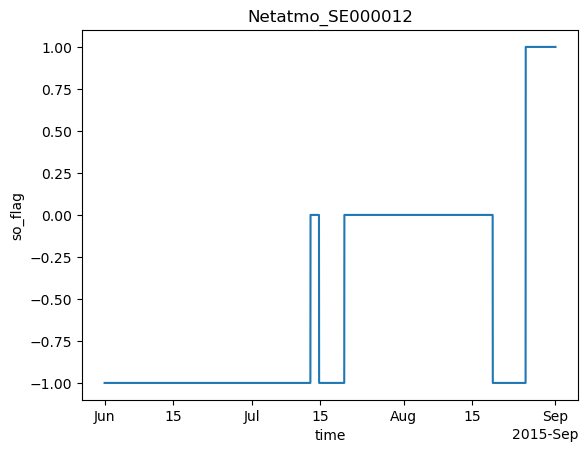

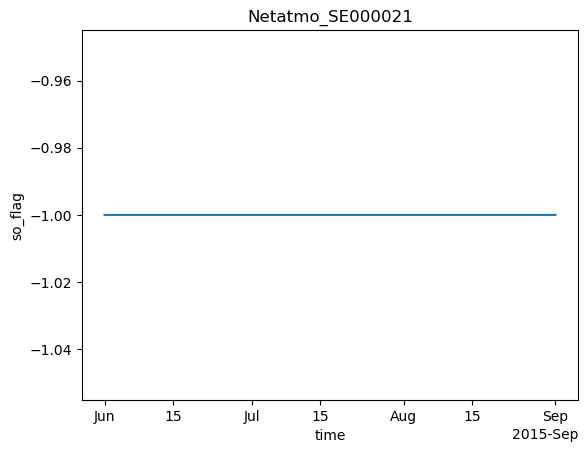

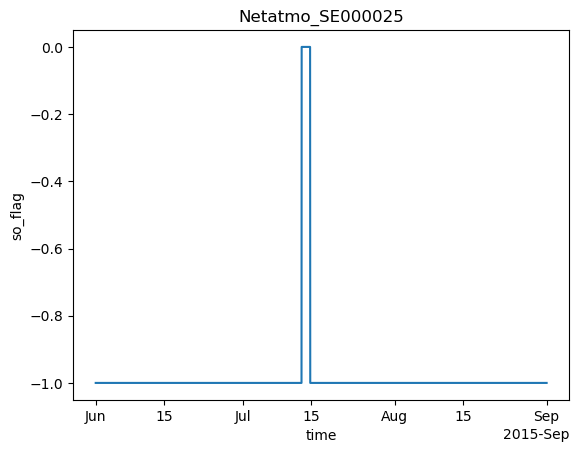

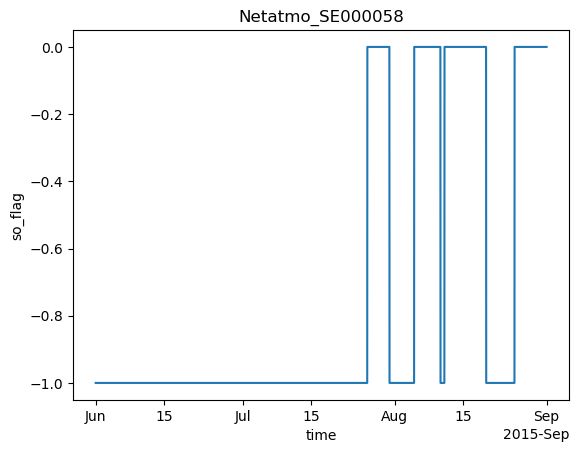

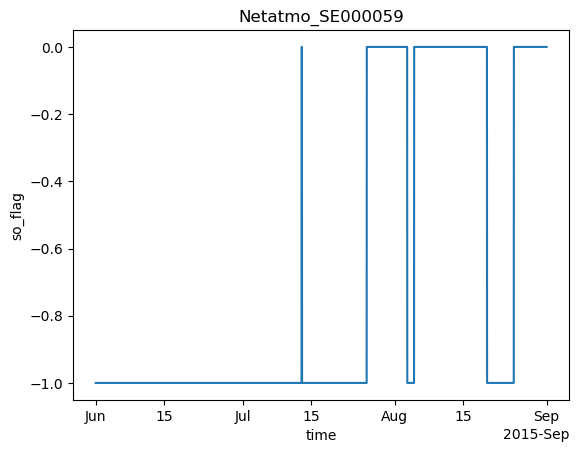

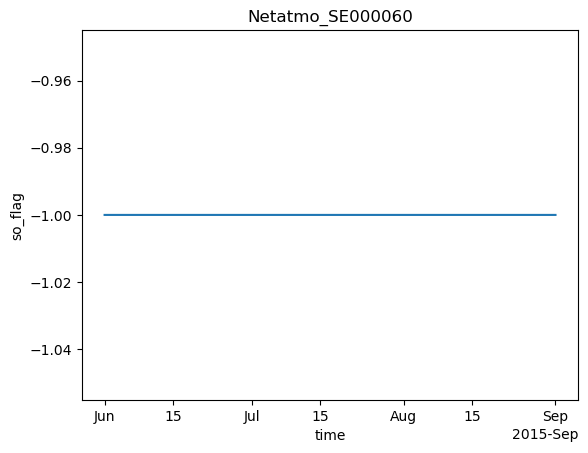

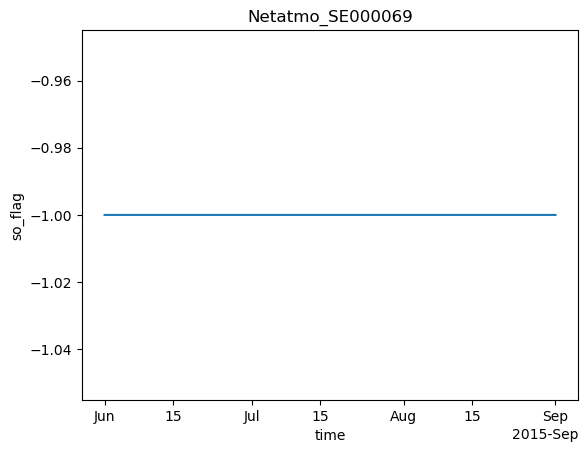

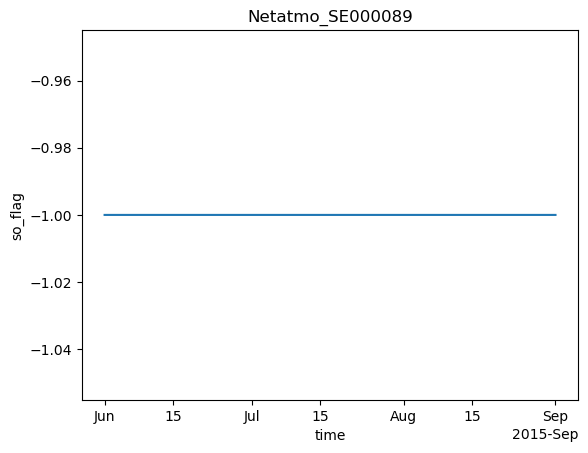

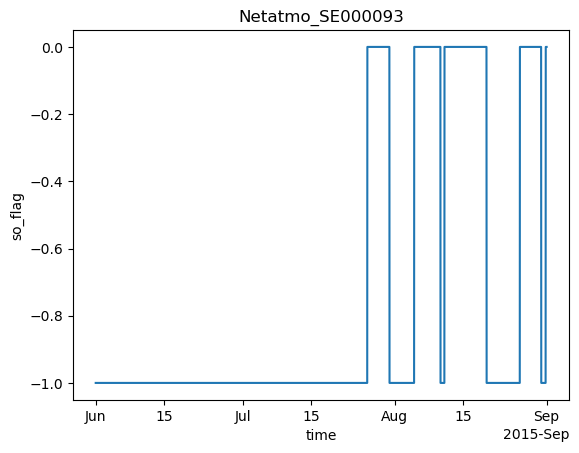

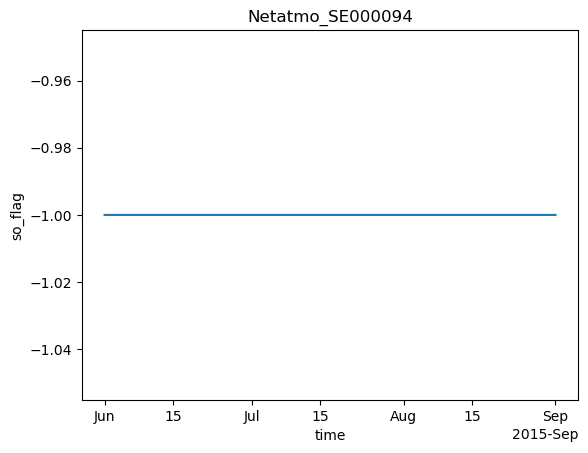

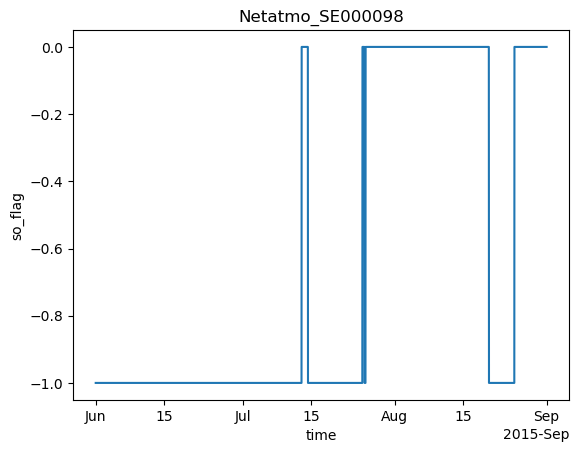

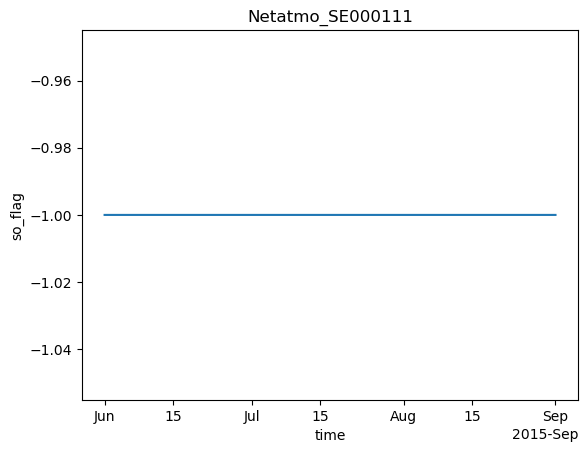

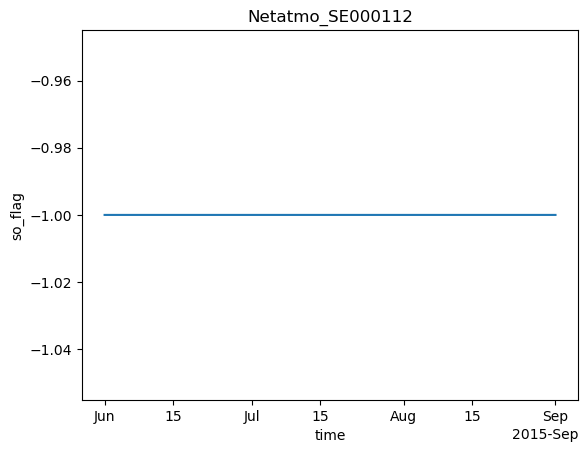

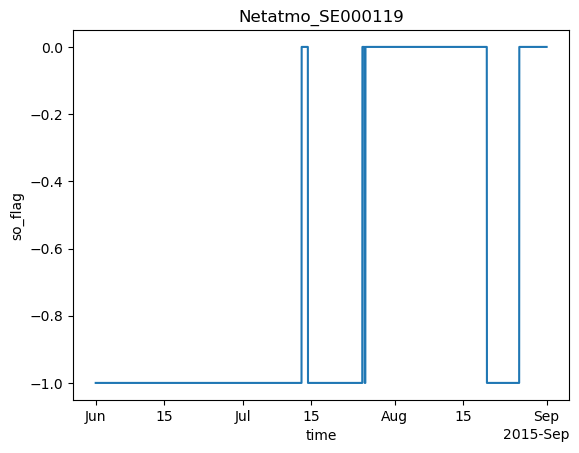

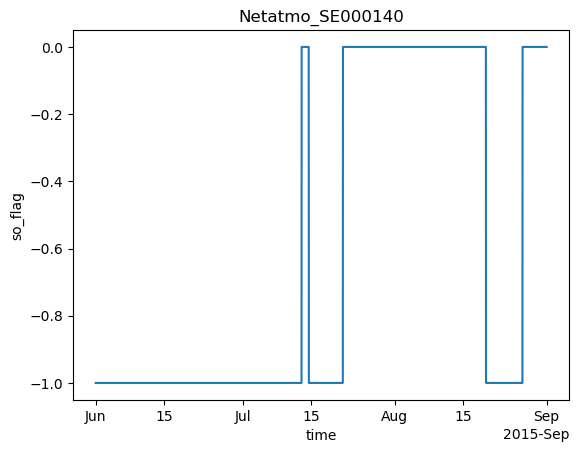

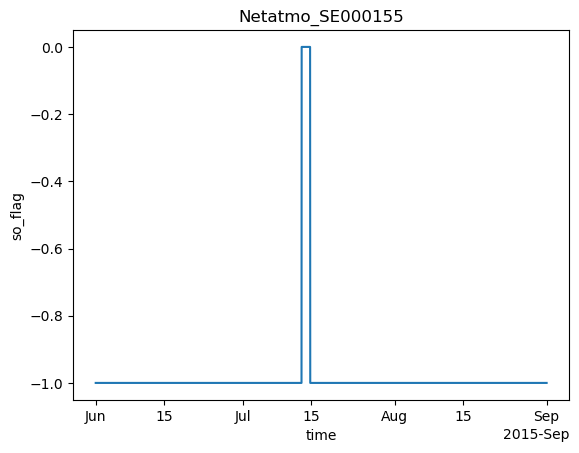

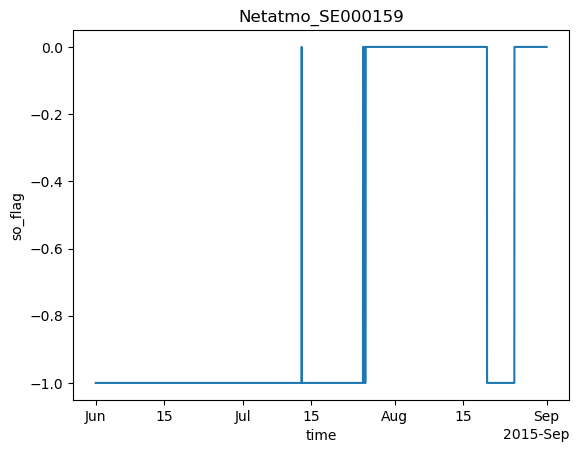

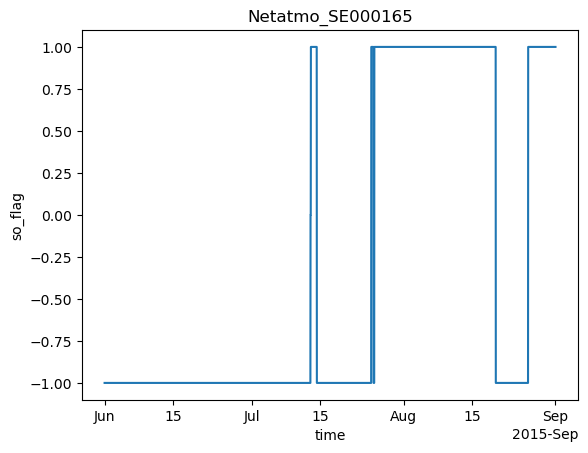

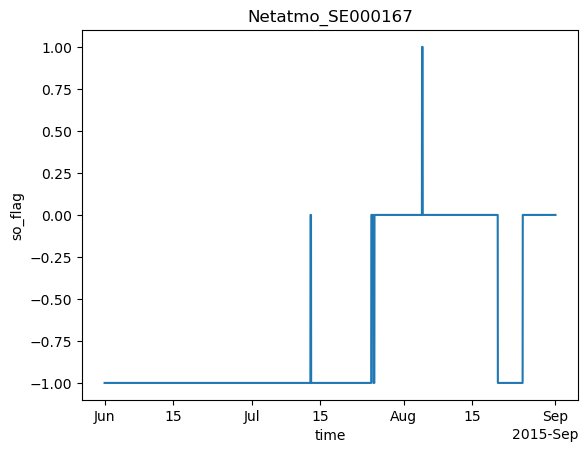

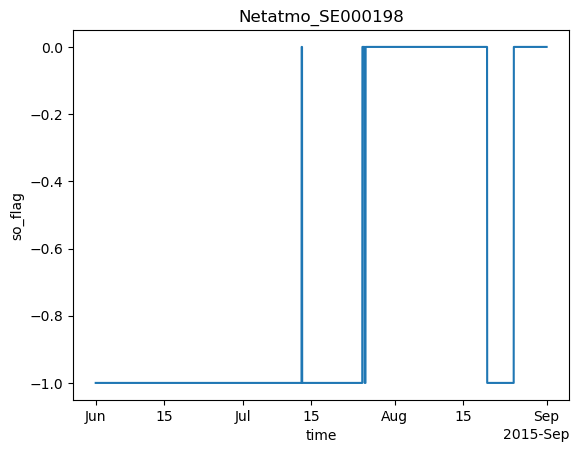

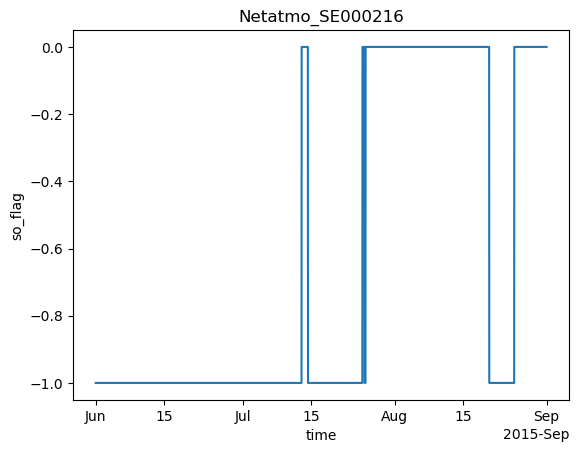

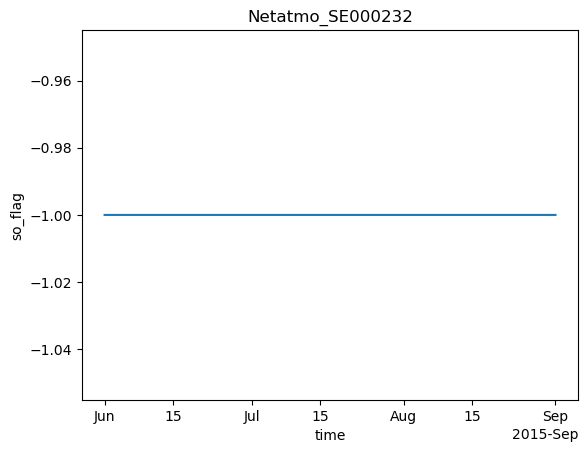

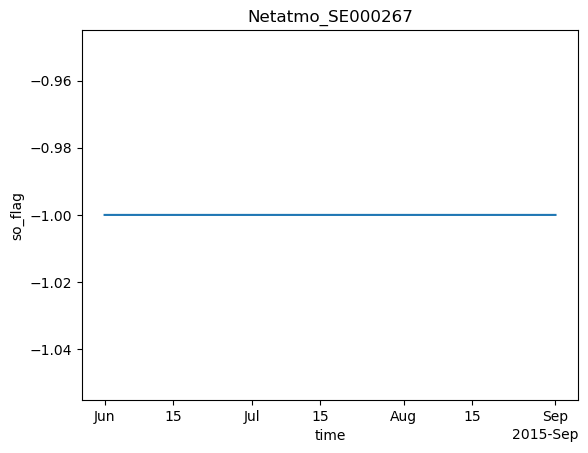

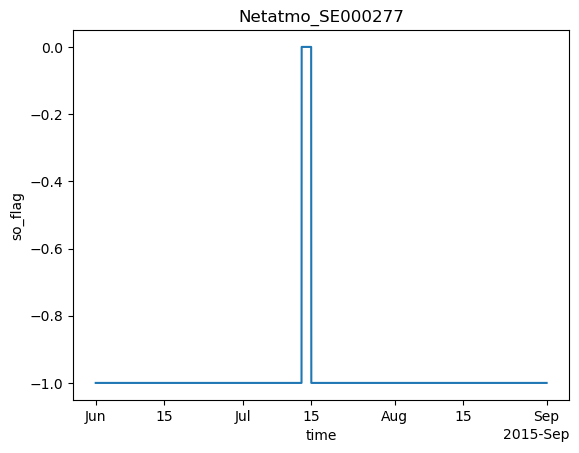

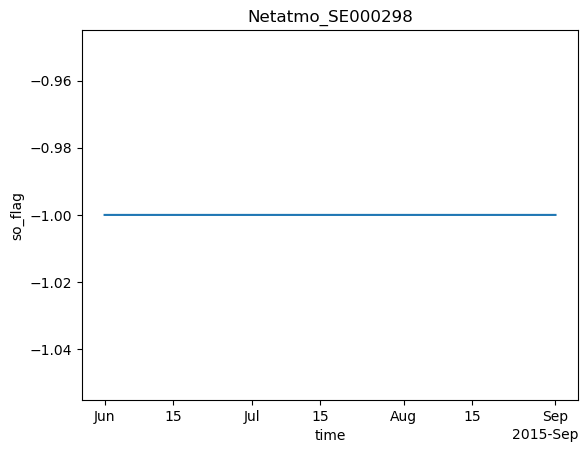

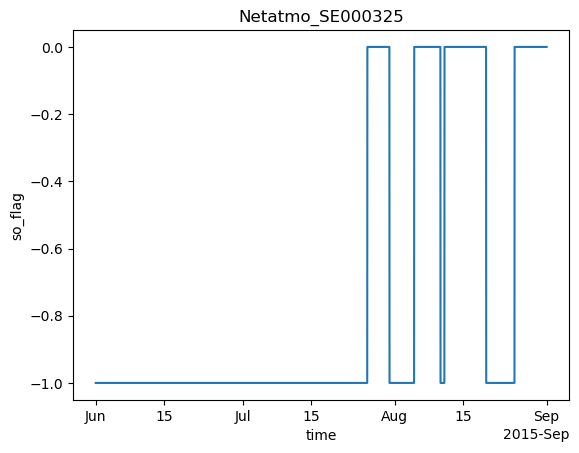

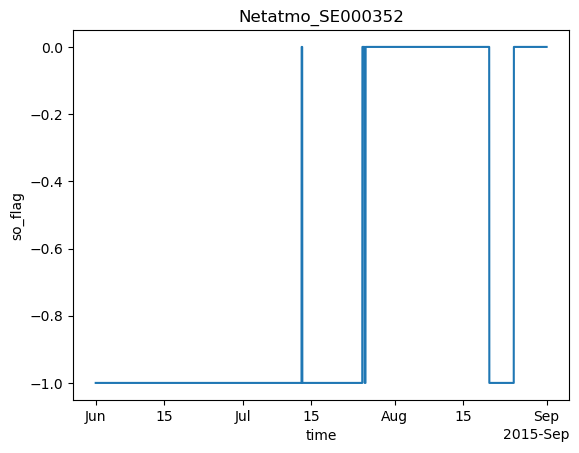

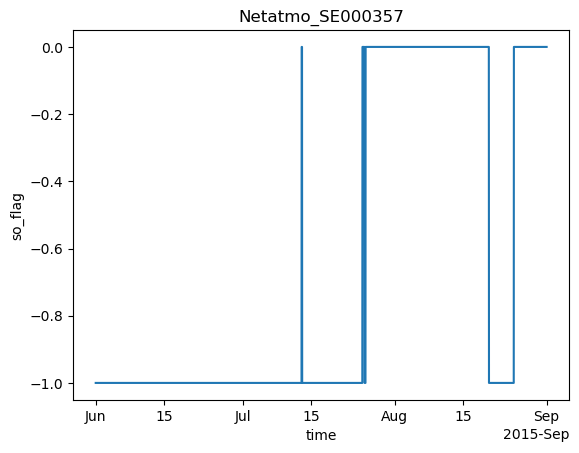

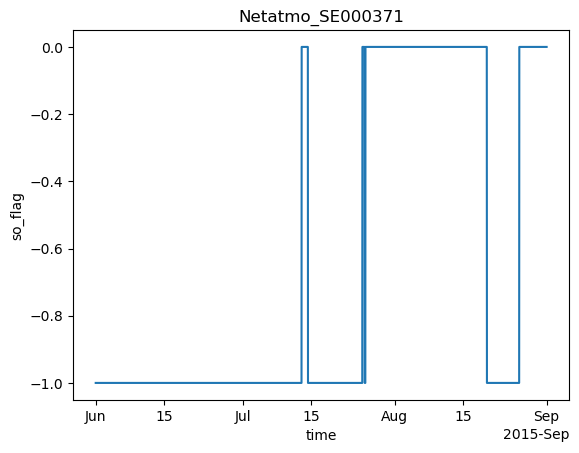

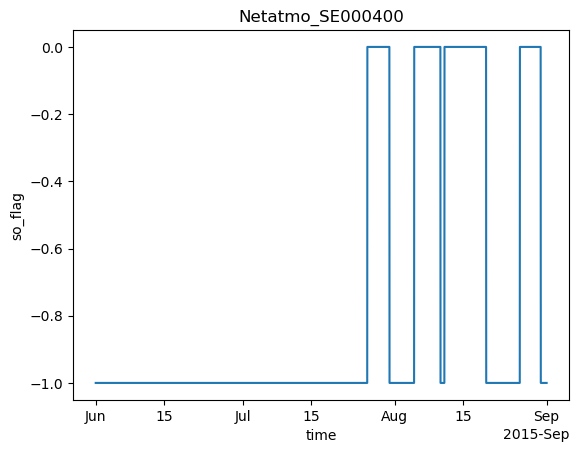

In [59]:
for i in ds_pws.id.data:
    plt.figure()
    ds_pws.so_flag.sel(id = i).plot()
    plt.title(str(i))
    plt.savefig('SO_plots/SO'+i+'.png')

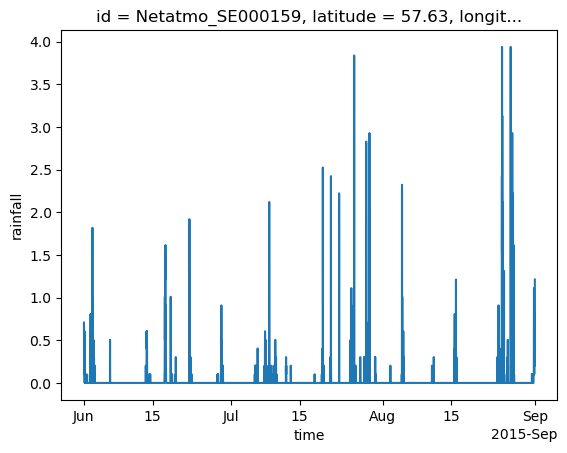

In [62]:
ds_pws.rainfall.sel(id = "Netatmo_SE000159").plot()

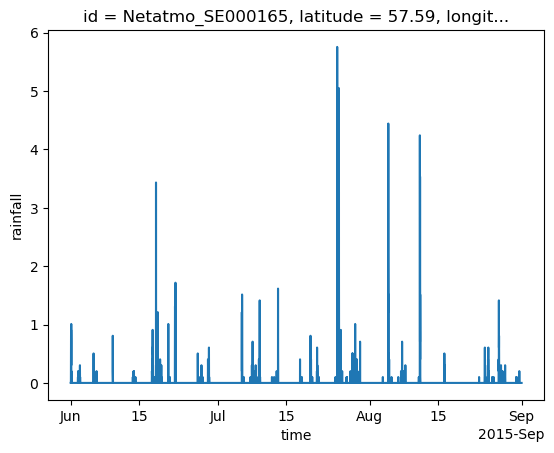

In [61]:
ds_pws.rainfall.sel(id = "Netatmo_SE000165").plot()

### Filter - flex

In [20]:
condition = (ds_pws_filtered['fz_flag'] != 1) & (ds_pws_filtered['hi_flag'] != 1) & (ds_pws_filtered['so_flag'] != 1)
ds_pws_filtered['rainfall_filtered'] = ds_pws_filtered['rainfall'].where(condition)

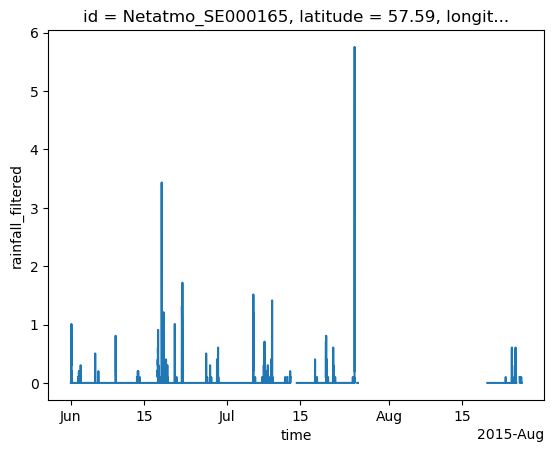

In [23]:
ds_pws_filtered.rainfall_filtered.sel(id = 'Netatmo_SE000165').plot()

In [25]:
ds_pws_filtered.to_netcdf('filtered_OpenMRG_dataset.nc')

### Filter - strict

In [26]:
condition1 = (ds_pws_filtered['fz_flag'] == 0) & (ds_pws_filtered['hi_flag'] == 0) & (ds_pws_filtered['so_flag'] == 0)
ds_pws_filtered['rainfall_filtered_strict'] = ds_pws_filtered['rainfall'].where(condition1)


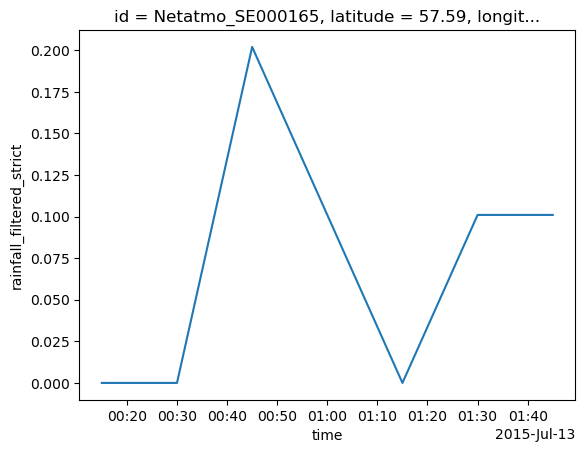

In [27]:
ds_pws_filtered.rainfall_filtered_strict.sel(id = 'Netatmo_SE000165').plot()

In [28]:
ds_pws_filtered.to_netcdf('filtered_OpenMRG_dataset_STRICT.nc')